In [2]:
import numpy as np
import pandas as pd
!pip install selenium
import selenium
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
import sys, io, os
import PIL
from PIL import Image, ImageOps
import requests
import time
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Sequential
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import random
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 73.0 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.7/475.7 kB 22.9 MB/s eta 0:00:00
  Attempting uninstall: websocket-client
    Found existing installation: websocket-client 1.7.0
    Uninstalling websocket-client-1.7.0:
      Successfully uninstalled websocket-client-1.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab 4.2.1 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.1.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.


In [3]:
tf.keras.__version__

'3.3.3'

In [4]:
data_dir = Path("/kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset")
train_dir= Path("/kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train")
test_dir = Path("/kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test")

#def fill_labels(dir, Print=False): # \ AI 1 / REAL 0 \
    #labels = []
#    for x,i in enumerate(os.walk(dir)):
#        print(x,i[1])
#        break
        #labels.extend( [int(i[0].split("/")[-1][:2]=="AI")]*len(i[2]) )
        #if Print: print(x,i[:2],"filled with",labels[-1])
    #return labels

#train_labels = fill_labels(train_dir, Print=True)
#test_labels = fill_labels(test_dir)
all_labels = next(os.walk(train_dir))[1]
all_labels = ([i for i in all_labels if "AI" in i]+[i for i in all_labels if "AI" not in i])
all_labels

['AI_SD_impressionism',
 'AI_LD_post_impressionism',
 'AI_LD_art_nouveau',
 'AI_LD_surrealism',
 'AI_LD_ukiyo-e',
 'AI_LD_romanticism',
 'AI_LD_baroque',
 'AI_LD_expressionism',
 'AI_SD_post_impressionism',
 'AI_SD_ukiyo-e',
 'AI_LD_renaissance',
 'AI_SD_renaissance',
 'AI_SD_romanticism',
 'AI_SD_realism',
 'AI_SD_baroque',
 'AI_SD_expressionism',
 'AI_LD_realism',
 'AI_SD_art_nouveau',
 'AI_SD_surrealism',
 'AI_LD_impressionism',
 'impressionism',
 'renaissance',
 'surrealism',
 'art_nouveau',
 'baroque',
 'expressionism',
 'romanticism',
 'ukiyo_e',
 'post_impressionism',
 'realism']

In [5]:
# Class weights for 01 classifying
#ones = train_labels.count(1)
#zeroes = len(train_labels)-ones
#class_weight = {0:len(train_labels)/2/zeroes, 1:len(train_labels)/2/ones} # Harmonic Mean= 1

In [12]:
# train_ds = tf.keras.utils.image_dataset_from_directory(
#     train_dir,
#     class_names=labels,
#     seed=69420,
#     image_size=(64, 64),
#     batch_size=64
# )

# val_ds = train_ds.enumerate() \
#                     .filter(lambda x,y: x % 10 == 0) \
#                     .map(lambda x,y: y)

# Error: Your train_ds ran out of data (WTF?)

# train_ds = train_ds.enumerate() \
#                     .filter(lambda x,y: x % 10 != 0) \
#                     .map(lambda x,y: y)


# test_ds = tf.keras.utils.image_dataset_from_directory(
#     test_dir,
#     shuffle=False,
#     class_names=labels,
#     seed=69,
#     image_size=(64, 64),
#     batch_size=64
# )


# train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
# val_ds   =   val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
# test_ds  =  test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

train_human = []
train_ai = []
# Loop through all directories
for directory in os.listdir(train_dir):
    if not directory.startswith('AI_'):
        train_human.append(os.path.join(train_dir, directory))
    else:
        train_ai.append(os.path.join(train_dir, directory))

# \\ HUMAN 1 ||| AI 0 //
        
filepaths = []
labels = []
all_labels = []
train_data = pd.DataFrame(columns=['filepath', 'label'])
for directory in train_human:
    all_labels.append(directory.split("/")[-1])
    for file in os.listdir(directory):
        filepath = os.path.join(directory, file)
        filepaths.append(filepath)
        labels.append(directory.split("/")[-1])

for directory in train_ai:
    label_name = directory.split("/")[-1].replace("-","_")
    label_name = label_name[:2]+label_name[5:]
    all_labels.append(label_name)
    for file in os.listdir(directory):
        filepath = os.path.join(directory, file)
        filepaths.append(filepath)
        labels.append(label_name)

data = pd.DataFrame({'filepath': filepaths, 'label': labels})
train_data = pd.concat([train_data, data], ignore_index=True)
train_data.iloc[:,1].value_counts()

label
AI_romanticism           10891
AI_ukiyo_e               10812
AI_surrealism            10748
AI_impressionism         10596
AI_realism               10480
AI_renaissance           10476
AI_expressionism         10420
AI_art_nouveau           10376
AI_post_impressionism    10204
AI_baroque               10012
renaissance               5000
impressionism             5000
art_nouveau               5000
surrealism                5000
post_impressionism        5000
realism                   5000
expressionism             5000
baroque                   5000
romanticism               5000
ukiyo_e                   5000
Name: count, dtype: int64

In [13]:
random_seed = 69
np.random.seed(random_seed)
# for label in ['AI_impressionism','AI_post_impressionism', 'AI_art_nouveau', 'AI_ukiyo_e', 'AI_romanticism',
#  'AI_baroque','AI_expressionism','AI_renaissance', 'AI_realism', 'AI_surrealism',]:

#     num_to_drop= len(train_data[train_data['label'] == label])-5000
#     ai_indices = train_data[train_data['label'] == label].index
#     indices_to_drop = np.random.choice(ai_indices, num_to_drop, replace=False)

#     train_data = train_data.drop(indices_to_drop)
#     train_data.reset_index(drop=True, inplace=True)

for label in all_labels:

    num_to_drop= len(train_data[train_data['label'] == label])-1000
    ai_indices = train_data[train_data['label'] == label].index
    indices_to_drop = np.random.choice(ai_indices, num_to_drop, replace=False)

    train_data = train_data.drop(indices_to_drop)
    train_data.reset_index(drop=True, inplace=True)

train_data.iloc[:,1].value_counts()

label
impressionism            1000
renaissance              1000
surrealism               1000
art_nouveau              1000
baroque                  1000
expressionism            1000
romanticism              1000
ukiyo_e                  1000
post_impressionism       1000
realism                  1000
AI_impressionism         1000
AI_post_impressionism    1000
AI_art_nouveau           1000
AI_surrealism            1000
AI_ukiyo_e               1000
AI_romanticism           1000
AI_baroque               1000
AI_expressionism         1000
AI_renaissance           1000
AI_realism               1000
Name: count, dtype: int64

In [14]:
# Piece of shit feature. Tries to load 200GB to RAM
# small_train_size = 1000 
# small_test_size = 100
# train_ds_easy = train_ds.shuffle(small_train_size).take(small_train_size)
# test_ds_easy = test_ds.shuffle(small_test_size).take(small_test_size)

In [15]:
test_human = []
test_ai = []

# Loop through all directories
for directory in os.listdir(test_dir):
    if not directory.startswith('AI_'):
        test_human.append(os.path.join(test_dir, directory))
    else:
        test_ai.append(os.path.join(test_dir, directory))

# \\ HUMAN 0 ||| AI 1 //
        
filepaths = []
labels = []
test_data = pd.DataFrame(columns=['filepath', 'label'])
for directory in test_human:
    for file in os.listdir(directory):
        filepath = os.path.join(directory, file)
        filepaths.append(filepath)
        labels.append(directory.split("/")[-1])

for directory in test_ai:
    label_name = directory.split("/")[-1].replace("-","_")
    label_name = label_name[:2]+label_name[5:]
    for file in os.listdir(directory):
        filepath = os.path.join(directory, file)
        filepaths.append(filepath)
        labels.append(label_name)

data = pd.DataFrame({'filepath': filepaths, 'label': labels})
test_data = pd.concat([test_data, data], ignore_index=True)


# for label in ['AI_impressionism','AI_post_impressionism', 'AI_art_nouveau', 'AI_ukiyo_e', 'AI_romanticism',
#  'AI_baroque','AI_expressionism','AI_renaissance', 'AI_realism', 'AI_surrealism',]:
for label in all_labels:

    num_to_drop= len(test_data[test_data['label'] == label])-100 #-1000
    ai_indices = test_data[test_data['label'] == label].index
    indices_to_drop = np.random.choice(ai_indices, num_to_drop, replace=False)

    test_data = test_data.drop(indices_to_drop)
    test_data.reset_index(drop=True, inplace=True)

test_data.iloc[:,1].value_counts()

label
impressionism            100
renaissance              100
surrealism               100
art_nouveau              100
baroque                  100
expressionism            100
romanticism              100
ukiyo_e                  100
post_impressionism       100
realism                  100
AI_impressionism         100
AI_post_impressionism    100
AI_art_nouveau           100
AI_surrealism            100
AI_ukiyo_e               100
AI_romanticism           100
AI_baroque               100
AI_expressionism         100
AI_renaissance           100
AI_realism               100
Name: count, dtype: int64

In [16]:
train_ds = train_data
test_ds = test_data
labels = ["impressionism", "renaissance","surrealism","art_nouveau","baroque","expressionism","romanticism",
          "ukiyo_e","post_impressionism","realism","AI_impressionism","AI_post_impressionism","AI_art_nouveau",
          "AI_surrealism","AI_ukiyo_e","AI_romanticism","AI_baroque","AI_expressionism","AI_renaissance","AI_realism"]               

class_names = {label:i for i,label in enumerate(labels)}
class_names

{'impressionism': 0,
 'renaissance': 1,
 'surrealism': 2,
 'art_nouveau': 3,
 'baroque': 4,
 'expressionism': 5,
 'romanticism': 6,
 'ukiyo_e': 7,
 'post_impressionism': 8,
 'realism': 9,
 'AI_impressionism': 10,
 'AI_post_impressionism': 11,
 'AI_art_nouveau': 12,
 'AI_surrealism': 13,
 'AI_ukiyo_e': 14,
 'AI_romanticism': 15,
 'AI_baroque': 16,
 'AI_expressionism': 17,
 'AI_renaissance': 18,
 'AI_realism': 19}

In [17]:
import shutil
!rm -rf test
!rmdir test
!rm -rf train
!rmdir train
os.mkdir("test")
os.mkdir("train")

for label in labels:
    os.mkdir(f"train/{label}")
    os.mkdir(f"test/{label}")
    
for i in range(len(train_data)):
    file, place = train_data.iloc[i,:]
    shutil.copy(f"{file}",f"train/{place}")
    
for i in range(len(test_data)):
    file, place = test_data.iloc[i,:]
    shutil.copy(f"{file}",f"test/{place}")

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


rmdir: failed to remove 'test': No such file or directory
rmdir: failed to remove 'train': No such file or directory


In [18]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    Path("/kaggle/working/train"),
    class_names=class_names,
    seed=69420,
    image_size=(128, 128),
    batch_size=128
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    Path("/kaggle/working/test"),
    shuffle=False,
    class_names=class_names,
    seed=69,
    image_size=(128, 128),
    batch_size=128
)

train_ds.class_names

Found 20000 files belonging to 20 classes.
Found 2000 files belonging to 20 classes.


{'impressionism': 0,
 'renaissance': 1,
 'surrealism': 2,
 'art_nouveau': 3,
 'baroque': 4,
 'expressionism': 5,
 'romanticism': 6,
 'ukiyo_e': 7,
 'post_impressionism': 8,
 'realism': 9,
 'AI_impressionism': 10,
 'AI_post_impressionism': 11,
 'AI_art_nouveau': 12,
 'AI_surrealism': 13,
 'AI_ukiyo_e': 14,
 'AI_romanticism': 15,
 'AI_baroque': 16,
 'AI_expressionism': 17,
 'AI_renaissance': 18,
 'AI_realism': 19}

In [23]:
tf.get_logger().setLevel('ERROR')

resnet50 = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(128, 128, 3)
)
resnet50.trainable = False
intermediate_output = resnet50.layers[-1].output

top_model = Sequential([
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, input_shape=resnet50.output_shape[1:], activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(20, activation='softmax')
])
final_output = top_model(intermediate_output)

model = keras.Model(inputs=resnet50.input,outputs=final_output)

model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

model_checkpoint = ModelCheckpoint('res50.keras', monitor='val_sparse_categorical_accuracy', save_best_only=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=3)
history = model.fit(train_ds, validation_data=test_ds, epochs=30, callbacks=[model_checkpoint, reduce_lr])

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  3/157 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 4.5202 - sparse_categorical_accuracy: 0.0586

I0000 00:00:1721615288.552926     140 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 2.1505 - sparse_categorical_accuracy: 0.3835
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.62400, saving model to res50.keras


W0000 00:00:1721615316.000368     141 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


157/157 ━━━━━━━━━━━━━━━━━━━━ 43s 180ms/step - loss: 2.1476 - sparse_categorical_accuracy: 0.3840 - val_loss: 1.1195 - val_sparse_categorical_accuracy: 0.6240 - learning_rate: 0.0010
Epoch 2/30
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 1.2251 - sparse_categorical_accuracy: 0.5827
Epoch 2: val_sparse_categorical_accuracy improved from 0.62400 to 0.63900, saving model to res50.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 89ms/step - loss: 1.2247 - sparse_categorical_accuracy: 0.5828 - val_loss: 1.0245 - val_sparse_categorical_accuracy: 0.6390 - learning_rate: 0.0010
Epoch 3/30
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 1.0651 - sparse_categorical_accuracy: 0.6265
Epoch 3: val_sparse_categorical_accuracy improved from 0.63900 to 0.65600, saving model to res50.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - loss: 1.0648 - sparse_categorical_accuracy: 0.6266 - val_loss: 0.9699 - val_sparse_categorical_accuracy: 0.6560 - learning_rate: 0.0010
Epoch 4/30
156/157 ━━━━━━━━━━━━━━━━━━━

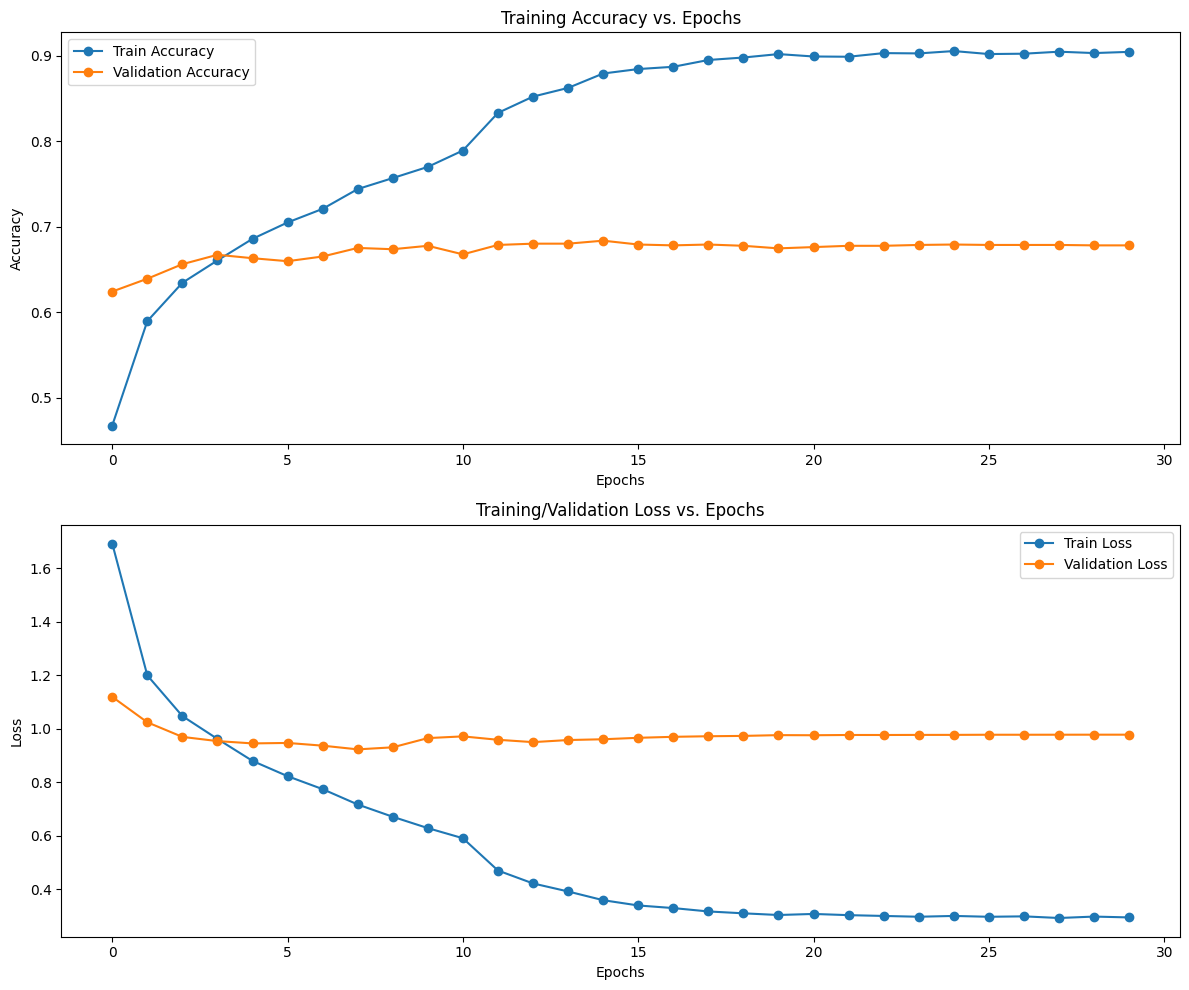

In [24]:
train_accuracy = history.history['sparse_categorical_accuracy']
val_accuracy = history.history['val_sparse_categorical_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')


plt.tight_layout()
plt.show()

In [ ]:
# rerun and rerun
#history = model.fit(train_ds, validation_data=test_ds, epochs=10, callbacks=[model_checkpoint, reduce_lr])

In [37]:
model = keras.models.load_model("res50.keras")

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_generator = ImageDataGenerator()

filepaths = []
labels = []
test_data = pd.DataFrame(columns=['filepath', 'label'])
for directory in test_human:
    for file in os.listdir(directory):
        filepath = os.path.join(directory, file)
        filepaths.append(filepath)
        labels.append("Human")

for directory in test_ai:
    label_name = directory.split("/")[-1].replace("-","_")
    label_name = label_name[:2]+label_name[5:]
    for file in os.listdir(directory):
        filepath = os.path.join(directory, file)
        filepaths.append(filepath)
        labels.append("AI")

data = pd.DataFrame({'filepath': filepaths, 'label': labels})
test_data = pd.concat([test_data, data], ignore_index=True)

test_dataset = test_generator.flow_from_dataframe(
    dataframe=test_data,
    x_col='filepath', 
    y_col='label',
    classes = {"Human":0,"AI":1},
    target_size = (128, 128),
    batch_size = 1,
    shuffle = False
)

test_dataset.class_indices

Found 30000 validated image filenames belonging to 2 classes.


{'Human': 0, 'AI': 1}

In [26]:
test_pred = model.predict(test_dataset)

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


30000/30000 ━━━━━━━━━━━━━━━━━━━━ 262s 9ms/step


In [27]:
set(test_pred[i].argmax() for i in range(500))
# SO relieved.

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19}

In [28]:
y_pred = test_pred.argmax(axis=1)//10
y_pred #0 Human, 1 AI

array([0, 0, 0, ..., 1, 1, 1])

In [29]:
# Evaluate the model
y_true = np.array([int(i=="AI") for i in test_data.iloc[:,1]])
print(classification_report(y_pred, y_true))
accuracy = (y_true==y_pred).sum()/len(y_true)
f"Achieved {accuracy*100:.4}% categorical accuracy. Holy hell"

              precision    recall  f1-score   support

           0       0.91      0.96      0.94      9473
           1       0.98      0.96      0.97     20527

    accuracy                           0.96     30000
   macro avg       0.95      0.96      0.95     30000
weighted avg       0.96      0.96      0.96     30000



'Achieved 95.93% categorical accuracy. Holy hell'

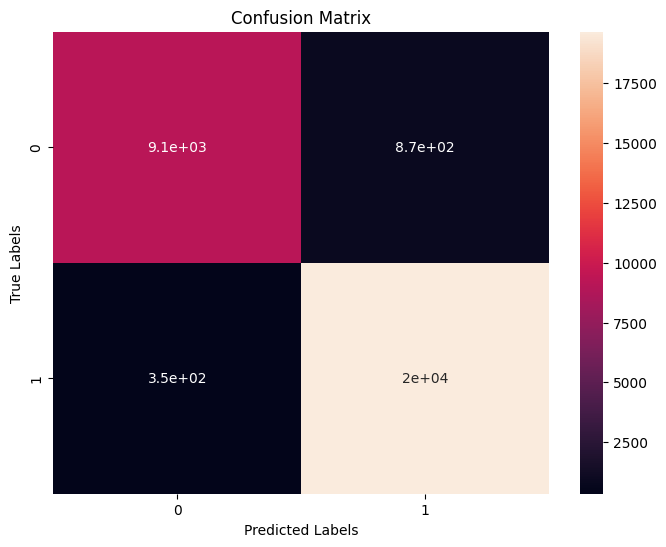

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
confusion_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Scrape the web, shall we?

In [31]:
# install google chrome
!wget https://dl.google.com/linux/linux_signing_key.pub
!sudo apt-key add linux_signing_key.pub
!echo 'deb [arch=amd64] http://dl.google.com/linux/chrome/deb/ stable main' >> /etc/apt/sources.list.d/google-chrome.list
!sudo apt-get -y update
!sudo apt-get install -y google-chrome-stable

# install chromedriver
# !apt-get install -y qq unzip
!wget -O /tmp/chromedriver.zip https://storage.googleapis.com/chrome-for-testing-public/126.0.6478.126/linux64/chromedriver-linux64.zip
!unzip /tmp/chromedriver.zip chromedriver-linux64/chromedriver -d /usr/local/bin/
!mv /usr/local/bin/chromedriver-linux64/chromedriver /usr/local/bin/chromedriver

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-07-22 02:42:17--  https://dl.google.com/linux/linux_signing_key.pub
Resolving dl.google.com (dl.google.com)... 74.125.142.190, 74.125.142.91, 74.125.142.136, ...
Connecting to dl.google.com (dl.google.com)|74.125.142.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16864 (16K) [application/octet-stream]
Saving to: 'linux_signing_key.pub'

linux_signing_key.p 100%[===================>]  16.47K  --.-KB/s    in 0s      

2024-07-22 02:42:17 (53.4 MB/s) - 'linux_signing_key.pub' saved [16864/16864]

OK
Get:1 http://dl.google.com/linux/chrome/deb stable InRelease [1825 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1581 B]
Get:3 https://packages.cloud.google.com/apt gcsfuse-focal InRelease [1225 B]   
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease                         
Get:5 http://security.ubuntu.com/ubuntu focal-security InRelease [128 kB]
Get:6 http://dl.google.com/linux/chrome/deb stable/main

In [32]:
!google-chrome --version
!chromedriver -v

Google Chrome 126.0.6478.182 
ChromeDriver 126.0.6478.126 (d36ace6122e0a59570e258d82441395206d60e1c-refs/branch-heads/6478@{#1591})


In [33]:
!rm -rf /kaggle/working/AI
!rm -rf /kaggle/working/NON

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--headless')
#chrome_options.add_argument('--disable-gpu')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument("--window-size=1920,1080")
driver = webdriver.Chrome(options=chrome_options)

urlAI="https://www.google.com/search?q=ai+art+filetype%3Ajpg&sca_esv=9cd90a64e37ec4fc&sca_upv=1&udm=2&biw=1536&bih=730&sxsrf=ADLYWIJOxqvpGyqsBYYqmRV_pRJvpYHMwg%3A1719876553212&ei=yTuDZuDKDKWNnesP-sm6mAM&ved=0ahUKEwig04u4_4aHAxWlRmcHHfqkDjMQ4dUDCBA&uact=5&oq=ai+generated+images+filetype%3Ajpg&gs_lp=Egxnd3Mtd2l6LXNlcnAiIGFpIGdlbmVyYXRlZCBpbWFnZXMgZmlsZXR5cGU6anBnSJQGUI0EWI0EcAF4AJABAJgBhgGgAYYBqgEDMC4xuAEDyAEA-AEBmAIAoAIAmAMAiAYBkgcAoAct&sclient=gws-wiz-serp"
urlNON="https://www.google.com/search?q=art+filetype%3Ajpg&sca_esv=9cd90a64e37ec4fc&sca_upv=1&udm=2&biw=1536&bih=730&sxsrf=ADLYWIJOxqvpGyqsBYYqmRV_pRJvpYHMwg%3A1719876553212&ei=yTuDZuDKDKWNnesP-sm6mAM&ved=0ahUKEwig04u4_4aHAxWlRmcHHfqkDjMQ4dUDCBA&uact=5&oq=ai+generated+images+filetype%3Ajpg&gs_lp=Egxnd3Mtd2l6LXNlcnAiIGFpIGdlbmVyYXRlZCBpbWFnZXMgZmlsZXR5cGU6anBnSJQGUI0EWI0EcAF4AJABAJgBhgGgAYYBqgEDMC4xuAEDyAEA-AEBmAIAoAIAmAMAiAYBkgcAoAct&sclient=gws-wiz-serp"

for url,folder_path in ((urlAI,"AI"),(urlNON,"NON")):
  driver.get(url)

  for x in range(4):
      driver.execute_script("window.scrollTo(0,document.body.scrollHeight);")
      time.sleep(2)

  imgResults = driver.find_elements(By.CLASS_NAME, "YQ4gaf")
  
  total=0
  for i,img in enumerate(imgResults):
    src = img.get_attribute('src')
    if "favicon" in src or "base64" in src: continue
    # Get the image from the URL
    image_content = requests.get(src).content
    file_name=str(i)
    image_file = io.BytesIO(image_content)
    image = Image.open(image_file).convert('RGB')
    if not os.path.exists(folder_path):
        os.mkdir(folder_path)
    file_path = os.path.join(folder_path,file_name+'.jpg')
    with open(file_path, 'wb') as f:
        image.save(f, "JPEG", quality=100)
    total+=1
  print(f"Saved {folder_path} - {total}")
    
driver.quit()

Saved AI - 500
Saved NON - 392


In [34]:
AI_PATH = Path("/kaggle/working/AI")
NON_PATH = Path("/kaggle/working/NON")
ai_list_path = list(AI_PATH.glob('*.jpg'))
non_list_path = list(NON_PATH.glob('*.jpg'))

## On an AI image

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Confidence=95.0%
Foiled! Model predicts AI tomfoolery


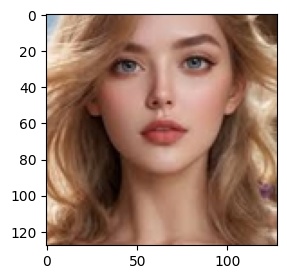

In [35]:
ai_img = random.choice(ai_list_path)
ai_img = Image.open(ai_img)
ai_img = ImageOps.fit(ai_img, (128,128), Image.Resampling.LANCZOS)

plt.figure(figsize = (3,3))
plt.imshow(ai_img)
ai_img = np.array(ai_img).reshape(-1,128,128,3)

confidence = (model.predict(ai_img).argmax(axis=1)/20)[0]
print(f"Confidence={confidence*100}%")
if confidence > 0.5: print("Foiled! Model predicts AI tomfoolery")
else: print("Safe! Model deems you AI-free")

## On a non-AI image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Confidence=15.0%
Safe! Model deems you AI-free


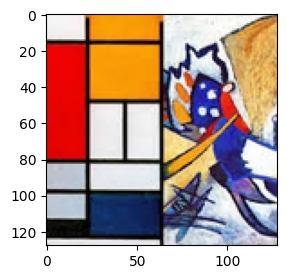

In [36]:
non_img = random.choice(non_list_path)
non_img = Image.open(non_img)
non_img = ImageOps.fit(non_img, (128,128), Image.Resampling.LANCZOS)

plt.figure(figsize = (3,3))
plt.imshow(non_img)
non_img = np.array(non_img).reshape(-1,128,128,3)


confidence = (model.predict(non_img).argmax(axis=1)/20)[0]
print(f"Confidence={confidence*100}%")
if confidence > 0.5: print("Foiled! Model predicts AI tomfoolery")
else: print("Safe! Model deems you AI-free")

In [1]:
# web_data_dir = "/kaggle/working"
# categories = ['NON', 'AI']

# web_data = load_data(web_data_dir, categories, img_size)

# random.shuffle(web_data)

# X_web = []; y_web = []

# for features, label in web_data:
#     X_web.append(features)
#     y_web.append(label)

# X_web = np.array(X_web).reshape(-1, img_size, img_size, 3)
# y_web = np.array(y_web)

# web_loss, web_acc = model.evaluate(X_web, y_web)
# print(f"Web Test Accuracy: {web_acc}")